In [1]:
# disable GPU. Remove this if you've compiled HOOMD for GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


# import the hoomd, htf packages
import hoomd
import math
import hoomd.htf as htf
import tensorflow as tf
import matplotlib.pyplot as plt
from MDAnalysis import Universe
import numpy as np

In [233]:
nlist = np.zeros((4, 3, 3), dtype=np.float32)
nlist[:, 0, :] = [4, -3, 2]
nlist = tf.constant(nlist)
with tf.GradientTape() as g:
    g.watch(nlist)    
    r = tnorm(nlist[:, :, :3], axis=2)
    rinv = tf.math.divide_no_nan(1.0, r)
    energy = tf.reduce_sum(rinv)
g.gradient(energy, nlist)



<tf.Tensor: shape=(4, 3, 3), dtype=float32, numpy=
array([[[-0.02561314,  0.01920986, -0.01280657],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.02561314,  0.01920986, -0.01280657],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.02561314,  0.01920986, -0.01280657],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.02561315,  0.01920986, -0.01280657],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]], dtype=float32)>

In [2]:
class RDF(htf.SimModel):
    def setup(self):
        self.rdf = tf.keras.metrics.MeanTensor()
    def compute(self, nlist):
        rdf = htf.compute_rdf(nlist, [0, 5])
        self.rdf(rdf)

In [3]:
# run the simulation
N = 256
period = 100
hoomd.context.initialize('--mode=cpu --notice-level=0')
rdf_model = RDF(64, output_forces=False)
tfcompute = htf.tfcompute(rdf_model)

rcut = 7.5
system = hoomd.init.create_lattice(
    unitcell=hoomd.lattice.sq(a=4.0),
    n=[int(math.sqrt(N)), int(math.sqrt(N))])
nlist = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=rcut, nlist=nlist)
lj.pair_coeff.set('A', 'A', epsilon=1, sigma=1)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.nve(group=hoomd.group.all(
        )).randomize_velocities(kT=0.5, seed=2)
tfcompute.attach(nlist, rcut)
hoomd.run(1e3)

snapshot = system.take_snapshot()
hoomd.dump.dcd(filename='ref.dcd', period=period, overwrite=True)
#hoomd.run(1e4)

In [4]:
ref_rdf = rdf_model.rdf.result().numpy()

In [5]:
class RBFExpansion(tf.keras.layers.Layer):
    def __init__(self, low, high, count):
        super(RBFExpansion, self).__init__(name='rbf-layer')
        self.low = low
        self.high = high
        self.centers = tf.cast(tf.linspace(low, high, count), dtype=tf.float32)
        self.gap = self.centers[1] - self.centers[0]

    def call(self, inputs):
        # input shpe
        x = tf.reshape(inputs, (-1,))
        rbf = tf.math.exp(-(x[:,tf.newaxis] - self.centers)**2 / self.gap)
        #remove 0s
        rbf *= tf.cast(x > 1e-5, tf.float32)[:,tf.newaxis]
        return tf.reshape(rbf, tf.concat((tf.shape(inputs), self.centers.shape), axis=0))

class WCARepulsion(tf.keras.layers.Layer):
    def __init__(self, start):
        super(WCARepulsion, self).__init__(name='wca-repulsion')
        # we make it big to ensure 
        self.sigma = self.add_weight(
            shape=(),
            regularizer=lambda x: -1e-3 * x,
            initializer=tf.keras.initializers.Constant(value=start)
        )
    def call(self, nlist, ):
        rinv = htf.nlist_rinv(nlist)
        true_sig = self.sigma
        rp = (true_sig * rinv)**6
        # make it so anything above cut is 0
        r = tf.norm(nlist[:,:,:3], axis=2)
        r_pair_energy = tf.cast(r < true_sig * 2**(1/3), tf.float32) * rp
        return tf.clip_by_value(r_pair_energy,0, 10)

In [77]:
class NlistNN(htf.SimModel):
    def setup(self, dim, top_neighs):
        self.dense1 = tf.keras.layers.Dense(dim, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(dim, use_bias=False)
        self.last = tf.keras.layers.Dense(1, use_bias=False)
        # just dummy single variable
        # regularization just pushes location of repulsion to right
        #self.repulsion = WCARepulsion(1.0)
        self.rbf = RBFExpansion(0, 5, dim)
        self.top_neighs = top_neighs
        self.jacobians = None
        self.rdf = tf.keras.metrics.MeanTensor()
        self.track_forces = True
    
    def compute(self, nlist):
        #tf.debugging.enable_check_numerics()
        if self.track_forces:
            with tf.GradientTape() as g1:
                energy = self.energy(nlist)                    
                forces = htf.compute_nlist_forces(nlist, energy)
            jac = g1.jacobian(forces, self.trainable_weights)
            if self.jacobians is None:
                self.jacobians = [tf.Variable(j, trainable=False) for j in jac]
            for ji, jj in zip(self.jacobians, jac):
                ji.assign_add(jj)
        else:
            forces = self.do_compute(nlist)
        return forces
    
    def energy(self, nlist):
        # Want closest, but not zeros. 
        delta = 1e-6
        r = htf.safe_norm(nlist[:,:,:3], axis=2, delta=delta)
        top_n = r * tf.cast(r > delta * 10, tf.float32)
        x = self.rbf(top_n)        
        # run through NN
        x = self.dense1(x)
        x = self.dense2(x)
        pair_energy = tf.reduce_sum(tf.squeeze(self.last(x)), axis=-1)# + tf.reduce_sum(self.repulsion(nlist), axis=-1)

        # get total energy
        energy = tf.reduce_sum(pair_energy)
        return energy

In [78]:
# run the simulation
N = 256
period = 10
hoomd.context.initialize('--mode=cpu')
hoomd.util.quiet_status()

# we do NOT compile!
model = NlistNN(64, dim=32, top_neighs=16, output_forces = True)
#model = TrainableLJ(64)

tfcompute = htf.tfcompute(model)
rcut = 7.5
system = hoomd.init.create_lattice(
    unitcell=hoomd.lattice.sq(a=4.0),
    n=[int(math.sqrt(N)), int(math.sqrt(N))])
nlist = hoomd.md.nlist.cell()
nvt = hoomd.md.integrate.nvt(group=hoomd.group.all(),kT=0.5, tau=0.2
        )
hoomd.md.integrate.mode_standard(dt = 0.005)
tfcompute.attach(nlist, r_cut=rcut, period = 10)

*Warning*: Ignoring new options, cannot change execution mode after initialization.


In [79]:
# initial RDF
#model.rdf.reset_states()
hoomd.run(25)
#init_rdf = model.rdf.result().numpy()

In [81]:
model.jacobians[2][0,0]

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-4.68492508e-05],
       [ 3.55243683e-05],
       [ 3.66345048e-05],
       [ 5.74290752e-05],
       [ 2.35289335e-05],
       [-5.23328781e-05],
       [ 5.54919243e-05],
       [-1.40368938e-05],
       [-8.37445259e-06],
       [-3.97562981e-05],
       [-5.09023666e-05],
       [-8.94665718e-05],
       [-2.47657299e-05],
       [ 6.98389485e-05],
       [-2.70307064e-05],
       [-1.92523003e-05],
       [ 1.37239695e-05],
       [-2.95937061e-05],
       [ 6.14523888e-05],
       [-6.74128532e-05],
       [-2.32458115e-05],
       [ 1.50501728e-05],
       [ 4.18424606e-05],
       [ 1.37090683e-06],
       [ 5.47170639e-05],
       [ 1.00731850e-05],
       [-2.84910202e-05],
       [ 2.49147415e-05],
       [ 9.71555710e-06],
       [ 8.15391541e-05],
       [-1.63316727e-05],
       [-2.87294388e-05]], dtype=float32)>

In [137]:
tf.reduce_sum(1 - tf.cast(tf.math.is_nan(model.jacobians[3]), tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=1024.0>

In [ ]:

steps = 5
compute_period = 10
hoomd.md.integrate.mode_standard(dt = period / steps / compute_period)
tfcompute.attach(nlist, r_cut=rcut, period = compute_period)


epochs = 1
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = []

model.track_forces = True
model.retrace_compute()

for e in range(epochs):
    universe = Universe('ref.dcd')
    labels = None
    for inputs, ts in htf.iter_from_trajectory(64, universe, r_cut=rcut, period=1):
        if labels is not None:
            system.restore_snapshot(snapshot)
            hoomd.run(steps)
            break
        labels = ts.positions
        snapshot.particles.position[:] = ts.positions[:]
    #optimizer.apply_gradients(zip(grad, model.trainable_weights))

In [162]:
model.jacobians[1]

<tf.Variable 'Variable:0' shape=(256, 32) dtype=float32, numpy=
array([[  6.8653665,   3.7646604,  -0.7094736, ...,   8.245194 ,
        -12.776527 ,  -0.7465802],
       [  6.8653665,   3.7646604,  -0.7094736, ...,   8.245194 ,
        -12.776527 ,  -0.7465802],
       [  6.8653665,   3.7646604,  -0.7094736, ...,   8.245194 ,
        -12.776527 ,  -0.7465802],
       ...,
       [  6.8653665,   3.7646604,  -0.7094736, ...,   8.245194 ,
        -12.776527 ,  -0.7465802],
       [  6.8653665,   3.7646604,  -0.7094736, ...,   8.245194 ,
        -12.776527 ,  -0.7465802],
       [  6.8653665,   3.7646604,  -0.7094736, ...,   8.245194 ,
        -12.776527 ,  -0.7465802]], dtype=float32)>

In [143]:
model.trainable_variables

[<tf.Variable 'dense_69/kernel:0' shape=(32, 32) dtype=float32, numpy=
 array([[ 0.09033999, -0.17770918,  0.11154124, ..., -0.13929938,
          0.17224735, -0.29142925],
        [-0.25860006,  0.02399307,  0.03695381, ..., -0.22499713,
         -0.03706607,  0.06185624],
        [-0.1691149 , -0.02454224, -0.23604444, ...,  0.20833251,
         -0.01133165, -0.21039572],
        ...,
        [-0.05816475, -0.001735  ,  0.20322224, ..., -0.19304359,
         -0.27727395, -0.11879544],
        [-0.28100318, -0.19328988, -0.28136352, ...,  0.06415319,
          0.23870322,  0.11587828],
        [ 0.0895589 , -0.2000601 , -0.22627085, ...,  0.09339127,
         -0.29637474, -0.15603204]], dtype=float32)>,
 <tf.Variable 'dense_69/bias:0' shape=(32,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>,
 <tf.Variable 'dense_70/kernel:0' shape=(32, 32) dt

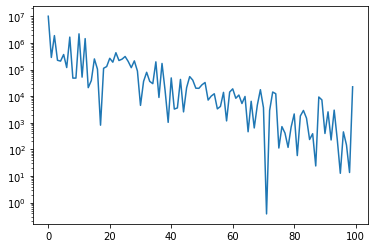

In [33]:
plt.plot(loss)
plt.yscale('log')

In [34]:
model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.0010097395>]

In [35]:
model.layers[3].trainable_weights

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0097394>]

In [36]:
# Final RDF
model.rdf.reset_states()
sample_cgmodel(1e4)
final_rdf = model.rdf.result().numpy()

In [37]:
final_rdf[1,:]

array([0.02500005, 0.07499987, 0.125     , 0.17499965, 0.22499974,
       0.27500048, 0.32500044, 0.375     , 0.42500037, 0.47499907,
       0.525001  , 0.5749989 , 0.625     , 0.6750014 , 0.7249998 ,
       0.7749998 , 0.8249983 , 0.875     , 0.92500174, 0.9750014 ,
       1.0249983 , 1.074998  , 1.125     , 1.1750021 , 1.2250024 ,
       1.2749976 , 1.3249984 , 1.375     , 1.4250005 , 1.4750029 ,
       1.5249969 , 1.5750006 , 1.625     , 1.6749988 , 1.7250034 ,
       1.7749965 , 1.8250022 , 1.875     , 1.9249972 , 1.9750038 ,
       2.0249963 , 2.0750034 , 2.125     , 2.1749961 , 2.225004  ,
       2.2749958 , 2.3250043 , 2.375     , 2.4249954 , 2.4750042 ,
       2.5249958 , 2.5750048 , 2.625     , 2.6749947 , 2.7250023 ,
       2.774998  , 2.8250058 , 2.875     , 2.9249942 , 2.9750001 ,
       3.025     , 3.0750062 , 3.125     , 3.1749935 , 3.224998  ,
       3.2750022 , 3.3250067 , 3.375     , 3.4249933 , 3.4749966 ,
       3.5250037 , 3.575007  , 3.625     , 3.674993  , 3.72499

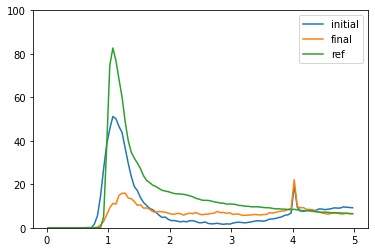

In [41]:
plt.plot(init_rdf[1,:], init_rdf[0,:], label='initial')
plt.plot(final_rdf[1,:], final_rdf[0,:], label='final')
plt.plot(ref_rdf[1,:], ref_rdf[0,:], label='ref')
plt.ylim(0,100)
plt.legend()

In [60]:
r = tf.linspace(0.5, 5, 1000)
output = htf.compute_pairwise(model, r)

ValueError: in user code:

    <ipython-input-56-1cf1dfe4a59f>:39 compute  *
        a.update_state(u)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/keras/utils/metrics_utils.py:90 decorated  **
        update_op = update_state_fn(*args, **kwargs)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:176 update_state_fn
        return ag_update_state(*args, **kwargs)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:2913 update_state  **
        self._build(values.shape)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:2885 _build
        'total', shape=shape, initializer=init_ops.zeros_initializer)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:308 add_weight
        aggregation=aggregation)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:614 add_weight
        caching_device=caching_device)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/training/tracking/base.py:750 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:145 make_variable
        shape=variable_shape if variable_shape else None)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:221 _variable_v1_call
        shape=shape)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:685 variable_capturing_scope
        lifted_initializer_graph=lifted_initializer_graph, **kwds)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/ops/variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py:226 __init__
        initial_value() if init_from_fn else initial_value,
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:114 __call__
        return array_ops.zeros(shape, dtype)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2747 wrapped
        tensor = fun(*args, **kwargs)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:2803 zeros
        shape = ops.convert_to_tensor(shape, dtype=dtypes.int32)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1499 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /home/whitead/miniconda3/envs/htf2/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:355 _tensor_shape_tensor_conversion_function
        "Cannot convert a partially known TensorShape to a Tensor: %s" % s)

    ValueError: Cannot convert a partially known TensorShape to a Tensor: (None, 32)


In [ ]:
plt.plot(r, output[1])